In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.modules.loss import MSELoss
from torch.utils.data import dataloader
import utils
from arguments import parse_args
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from IPython.display import clear_output as clear

%matplotlib inline
%load_ext autoreload
%autoreload 2

class LossLogger(object):
    def __init__(self, decay):
        self.loss_history = []
        self.loss = 0
        self.decay = decay
        
    def push(self, loss):
        self.loss_history.append(loss)
        self.loss *= self.decay
        self.loss += loss * (1-self.decay)
        
    def loss(self):
        return self.loss
    
    def flush(self):
        self.loss = 0

    def history(self):
        return self.loss_history
    
    
logger = LossLogger(0.8)

In [2]:
args = parse_args(["--alg", "VDSR", "--point_num", "5000", "--description", "psnr+ssim", "--lr", "1e-3", "--epoch", "200"])

In [3]:
# Training Preparation
utils.set_seed_everywhere(args.seed)

device = torch.device('cuda:0' if args.device == 'gpu' and torch.cuda.is_available() else 'cpu')
print(device)

train_dataset = utils.TrainDataset(args)
train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True,
                                collate_fn=utils.collect_function)

loss_function = nn.MSELoss()

# loss_function = lambda img_gt, img_pred : -utils.psnr(img_gt, img_pred) - utils.ssim(img_gt, img_pred)

model = utils.make_model(args).to(device)
model = model.float()

optimizer = optim.Adam(params=model.parameters(),lr=args.lr)

e = 0

cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


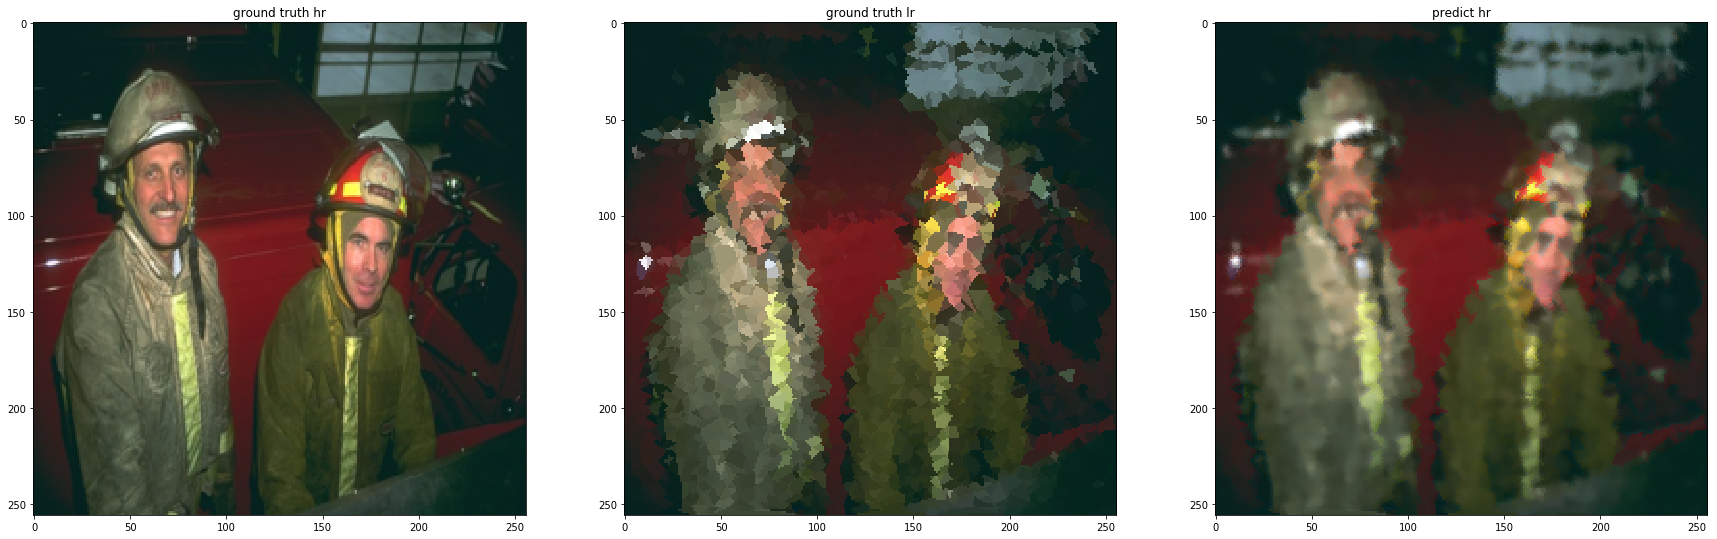

epoch: 3 | idx: 44 | loss: -0.875745831933891 | psnr: 67.58594512939453 | ssim: 0.5846279859542847


KeyboardInterrupt: 

In [4]:
# Start training
# train_loader = tqdm.tqdm(train_loader)

for _ in range(10):
    model.train()
    for idx, img_pair in enumerate(train_loader):
        
        img_hr = img_pair['hr'].to(device)
        img_lr = img_pair['lr'].to(device)
        
        if args.alg == 'CNF':
            img_predict, loss = model(x_hr=img_hr, xlr=img_lr)
        else:
            img_predict = model(img_lr)
            # loss = loss_function(img_hr, img_predict)
            psnr = utils.psnr(img_hr, img_predict)
            ssim = utils.ssim(img_hr, img_predict)
            loss = -psnr/300 - ssim


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        logger.push(loss.item())
        clear()
        utils.show_gt_and_pred(img_hr=img_hr[0].permute(1,2,0).cpu(), img_lr=img_lr[0].permute(1,2,0).cpu(), pred_hr=img_predict[0].permute(1,2,0).detach().cpu(), figsize=(30, 30))
        # train_loader.set_description(f"epoch: {e} | idx: {idx} | loss: {logger.loss}")
        print(f"epoch: {e} | idx: {idx} | loss: {logger.loss} | psnr: {psnr} | ssim: {ssim}")


    utils.save_model(model, e, args)
    e += 1